In [1]:
import numpy as np
import sklearn as sk
from sklearn import mixture, cluster,metrics, neural_network

In [2]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
import json 

with open('./data/train.jsonl', 'r') as json_file:
    json_list = list(json_file)
  
text_list = list() # storing in lists
id_list = list()
labels_list = list()

for json_str in json_list: 
    result = json.loads(json_str)
    id_list.append(f"{result['id']}")

    text_list.append(f"{result['text']}")
    labels_list.append(f"{result['label']}")

with open('./data/test_seen.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list: 
    result = json.loads(json_str)
    id_list.append(f"{result['id']}")

    text_list.append(f"{result['text']}")
    labels_list.append(f"{result['label']}")

In [4]:
import pandas as pd 
df = pd.DataFrame({"id": id_list, "text": text_list}) #converting into dataframes

df_label = pd.DataFrame({"id": id_list, "label": labels_list})

df_label_sort = df_label.sort_values(by="id")


labels_true = df_label_sort["label"].to_numpy().astype(int)
print(labels_true)

[1 0 0 ... 1 0 0]


In [5]:
df.to_csv("caption_initial.csv") # saving in CSV

In [6]:
tokenized_list = list()

for i in df['text']:
  i = "[CLS] " + i + " [SEP]"
  tokenized_text = tokenizer.tokenize(i)
  tokenized_list.append(tokenized_text)

indexed_list = list()

for i in tokenized_list:
  indexed_list.append(tokenizer.convert_tokens_to_ids(i))

In [7]:
segment_list = list()

for i in tokenized_list:
  segment_list.append([1] * len(i))

In [8]:
# Convert inputs to PyTorch tensors

tokens_tensor_list = list()
segments_tensor_list = list()

for i in indexed_list:
  tokens_tensor_list.append(torch.tensor([i]))

for i in segment_list:
  segments_tensor_list.append(torch.tensor([i]))

In [9]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
outputs_list = list()
hidden_states_list = list() 
with torch.no_grad():
  for (i,j) in zip(tokens_tensor_list,segments_tensor_list):
      outputs = model(i,j)
      outputs_list.append(outputs)
      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states_list.append(outputs[2])

# Fusion Technique

In [79]:
fusion = [0,2]

if(fusion[0] == 0):
    layer = 2
elif(fusion[0] == 1):
    layer = 8
else:
    layer = 12
    
if(fusion[1] == 0):
    file_name = "data/006_layer2.pkl"
elif(fusion[1] == 1):
    file_name = "data/008_layer4.pkl"
else:
    file_name = "data/010_fc.pkl"


In [80]:
# `hidden_states` has shape [13 x 1 x 22 x 768]
sentence_embedding_list = list()

for i in hidden_states_list:
  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = i[layer-1][0][:][:] #first dimension defines the layer of feature extraction

  # Calculate the average of all 22 token vectors.
  sentence_embedding_list.append(torch.mean(token_vecs, dim=0))

#sort it accordig to id

df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list}) #converting into dataframes

df2 = df2.sort_values(by = "id", ascending = True)

In [81]:
import pickle as p

with open(file_name, 'rb') as f:
    data_image_in = p.load(f)

In [82]:
data_text = torch.cat(df2["features"].tolist()).numpy().reshape(9500,768)
data_image = data_image_in.to_numpy()[0:9500,1:]

# Concatenation

In [ ]:
layer = 10
sentence_embedding_list = list()

for i in hidden_states_list:
  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = i[layer-1][0][:][:] #first dimension defines the layer of feature extraction

  # Calculate the average of all 22 token vectors.
  sentence_embedding_list.append(torch.mean(token_vecs, dim=0))

#sort it accordig to id

df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list}) #converting into dataframes

df2_10 = df2.sort_values(by = "id", ascending = True)

layer = 11
sentence_embedding_list = list()

for i in hidden_states_list:
  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = i[layer-1][0][:][:] #first dimension defines the layer of feature extraction

  # Calculate the average of all 22 token vectors.
  sentence_embedding_list.append(torch.mean(token_vecs, dim=0))

#sort it accordig to id

df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list}) #converting into dataframes

df2_11 = df2.sort_values(by = "id", ascending = True)

layer = 12
sentence_embedding_list = list()

for i in hidden_states_list:
  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = i[layer-1][0][:][:] #first dimension defines the layer of feature extraction

  # Calculate the average of all 22 token vectors.
  sentence_embedding_list.append(torch.mean(token_vecs, dim=0))

#sort it accordig to id

df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list}) #converting into dataframes

df2_12 = df2.sort_values(by = "id", ascending = True)

layer = 13
sentence_embedding_list = list()

for i in hidden_states_list:
  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = i[layer-1][0][:][:] #first dimension defines the layer of feature extraction

  # Calculate the average of all 22 token vectors.
  sentence_embedding_list.append(torch.mean(token_vecs, dim=0))

#sort it accordig to id

df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list}) #converting into dataframes

df2_13 = df2.sort_values(by = "id", ascending = True)

layer = 7
sentence_embedding_list = list()

for i in hidden_states_list:
  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = i[layer-1][0][:][:] #first dimension defines the layer of feature extraction

  # Calculate the average of all 22 token vectors.
  sentence_embedding_list.append(torch.mean(token_vecs, dim=0))

#sort it accordig to id

df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list}) #converting into dataframes

df2_7 = df2.sort_values(by = "id", ascending = True)

data_text_7 = torch.cat(df2_7["features"].tolist()).numpy().reshape(9500,768)
data_text_10 = torch.cat(df2_10["features"].tolist()).numpy().reshape(9500,768)
data_text_11 = torch.cat(df2_11["features"].tolist()).numpy().reshape(9500,768)
data_text_12 = torch.cat(df2_12["features"].tolist()).numpy().reshape(9500,768)
data_text_13 = torch.cat(df2_13["features"].tolist()).numpy().reshape(9500,768)

data_text = np.concatenate((data_text_7,data_text_11,data_text_13), axis = 1)
# data_text = data_text_9



In [ ]:
import pickle as p

file_name = "data/010_fc.pkl"

with open(file_name, 'rb') as f:
    data_image_in = p.load(f)
data_image = data_image_in.to_numpy()[0:9500,1:]

# file_name = "data/008_layer4.pkl"

# with open(file_name, 'rb') as f:
#     data_image_in = p.load(f)
# data_image_2 = data_image_in.to_numpy()[0:9500,1:]

# data_image = np.concatenate((data_image_2,data_image_1), axis = 1)

# Normalization

In [83]:

#Normalization code
data_reduced = np.concatenate((data_image,data_text),axis = 1)
data_normalized = (data_reduced-np.mean(data_reduced, axis = 0))/(np.var(data_reduced, axis = 0)**0.5+1e-3)
print(data_normalized.shape)

(9500, 1767)


In [84]:
# #Normalization code
# data_image_red = (data_image-np.mean(data_image))/(np.var(data_image)**0.5+1e-3)
# data_text_red = (data_text-np.mean(data_text))/(np.var(data_text)**0.5+1e-3)
# data_normalized = np.concatenate((data_image_red,data_text_red),axis = 1)
# print(data_normalized.shape)

In [85]:
input_size = data_normalized.shape[1]

In [86]:
x_train = data_normalized[0:8500,:]
y_train = labels_true[0:8500]

x_val = data_normalized[8500:9500,:]
y_val = labels_true[8500:9500]

In [87]:
# x_train = [data_image[0:8500,:],data_text[0:8500,:]]
# y_train = labels_true[0:8500]
# input_size1 = data_image.shape[1]
# input_size2 = data_text.shape[1]

# x_val = [data_image[8500:9500,:],data_text[8500:9500,:]]
# y_val = labels_true[8500:9500]

# Supervised Model

In [88]:


def skip_model(input_size):
    inp = tf.keras.Input(input_size,)
    
    dense1 = Dense(256)(inp)
    act1 = LeakyReLU(0.1)(dense1)
    drop1 = Dropout(0.5)(act1)
    
    dense2 = Dense(256)(drop1)
    act2 = LeakyReLU(0.1)(dense2)
    drop2 = Dropout(0.5)(act2)
    
    skip1 = Add()([drop1, drop2])
    
    dense3 = Dense(256)(skip1)
    act3 = LeakyReLU(0.1)(dense3)
    drop3 = Dropout(0.5)(act3)
    
    skip2 = Add()([drop1, drop3])
    
    dense4 = Dense(256)(skip2)
    act4 = LeakyReLU(0.1)(dense4)
    drop4 = Dropout(0.5)(act4)
    
    skip3 = Add()([drop1, drop4])
    
    dense5 = Dense(256)(skip3)
    act5 = LeakyReLU(0.1)(dense5)
    drop5 = Dropout(0.5)(act5)
    
    skip4 = Add()([drop1, drop5])
    
#     dense6 = Dense(256)(skip4)
#     act6 = LeakyReLU(0.1)(dense6)
#     drop6 = Dropout(0.5)(act6)
    
#     skip5 = Add()([drop1, drop6])
    
    dense6 = Dense(256)(skip4)
    act6 = LeakyReLU(0.1)(dense6)
    
    out = Dense(1, activation='sigmoid')(act6)
    
    model = Model(inputs = inp, outputs = out)
    
    return model

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, schedules


model = Sequential()
model.add(tf.keras.Input(input_size,))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))

model.add(Dense(1, activation='sigmoid'))
model = skip_model(input_size)
# model = fusion_model(input_size1, input_size2)
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=500,
    decay_rate=0.9)
opt = SGD(learning_rate=0.01)
metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
model.summary()
print("Fit model on training data")
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_val, y_val),)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1767)]       0           []                               
                                                                                                  
 dense_105 (Dense)              (None, 256)          452608      ['input_19[0][0]']               
                                                                                                  
 leaky_re_lu_87 (LeakyReLU)     (None, 256)          0           ['dense_105[0][0]']              
                                                                                                  
 dropout_56 (Dropout)           (None, 256)          0           ['leaky_re_lu_87[0][0]']         
                                                                                            

266/266 [==============================] - 21s 78ms/step - loss: 0.5753 - binary_accuracy: 0.7033 - auc_13: 0.7339 - precision_2: 0.6393 - recall_2: 0.4411 - val_loss: 0.6028 - val_binary_accuracy: 0.6790 - val_auc_13: 0.7126 - val_precision_2: 0.5959 - val_recall_2: 0.5297
Epoch 11/15
266/266 [==============================] - 21s 79ms/step - loss: 0.5705 - binary_accuracy: 0.7020 - auc_13: 0.7394 - precision_2: 0.6336 - recall_2: 0.4475 - val_loss: 0.6029 - val_binary_accuracy: 0.6810 - val_auc_13: 0.7111 - val_precision_2: 0.5960 - val_recall_2: 0.5452
Epoch 12/15
266/266 [==============================] - 21s 79ms/step - loss: 0.5630 - binary_accuracy: 0.7131 - auc_13: 0.7494 - precision_2: 0.6533 - recall_2: 0.4660 - val_loss: 0.6013 - val_binary_accuracy: 0.6790 - val_auc_13: 0.7165 - val_precision_2: 0.5907 - val_recall_2: 0.5556
Epoch 13/15
266/266 [==============================] - 21s 79ms/step - loss: 0.5546 - binary_accuracy: 0.7174 - auc_13: 0.7612 - precision_2: 0.6532 - 

dict_keys(['loss', 'binary_accuracy', 'auc_10', 'val_loss', 'val_binary_accuracy', 'val_auc_10'])


Text(0, 0.5, 'Loss')

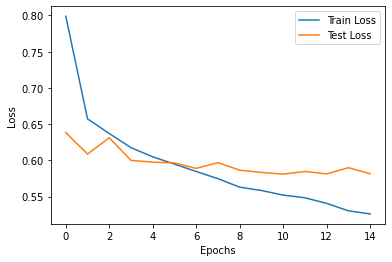

In [66]:
from matplotlib import pyplot
print(history.history.keys())
x = np.arange(15)
# pyplot.plot(x, history.history["loss"],x, history.history["val_loss"])
fig, ax = plt.subplots()
line1, = ax.plot(history.history["loss"], label='Train Loss')
line2, = ax.plot(history.history["val_loss"], label='Test Loss')
ax.legend(handles=[line1, line2])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [62]:
print(history.history["val_auc_7"])

[0.6234788298606873, 0.674677848815918, 0.695644736289978, 0.7067942023277283, 0.7036222219467163, 0.6903376579284668, 0.6961990594863892, 0.6780901551246643, 0.6717861294746399, 0.6782419085502625, 0.6604027152061462, 0.6675813794136047, 0.6702538728713989, 0.6698281764984131, 0.6683759689331055]


In [ ]:
data_text_list= []
for layer in range(13):
    sentence_embedding_list = list()
    for i in hidden_states_list:
        token_vecs = i[layer-1][0][:][:]
        sentence_embedding_list.append(torch.mean(token_vecs, dim=0))
    df2 = pd.DataFrame({"id": id_list, "features": sentence_embedding_list})
    df2 = df2.sort_values(by = "id", ascending = True)
    data_text_list.append(torch.cat(df2_11["features"].tolist()).numpy().reshape(9500,768))

In [ ]:

num_models = 10

test_out_prob = []
hist = []
for i in range(num_models):
    num_feat = 3
    feautre_idx = np.random.choice(np.arange(13), size = num_feat)
    print(feautre_idx)
    data_concat = data_text_list[feautre_idx[0]]
    for i in range(num_feat-1):
        data_concat = np.concatenate((data_concat,data_text_list[feautre_idx[i+1]]), axis = 1)
    data_reduced = np.concatenate((data_image,data_concat),axis = 1)
    data_normalized = (data_reduced-np.mean(data_reduced, axis = 0))/(np.var(data_reduced, axis = 0)**0.5+1e-3)
    
    x_train = data_normalized[0:8500,:]
    y_train = labels_true[0:8500]

    x_val = data_normalized[8500:9500,:]
    y_val = labels_true[8500:9500]
    input_size = data_normalized.shape[1]
    model = skip_model(input_size)
    
    metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=4,verbose=1,mode="auto",baseline=None,restore_best_weights=False)
    
    model.compile(optimizer=SGD(learning_rate=0.005), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

    print("Fit model on training data")
    history = model.fit(x_train,y_train,batch_size=32,epochs=30,validation_data=(x_val, y_val), callbacks=[callback])
    hist.append(history)
    test_out_prob.append(model(x_val))



In [ ]:
test_out_prob_array = np.array(test_out_prob)
final_out = np.mean(test_out_prob, axis = 0)
final_score = metrics.roc_auc_score(y_val, final_out)
print("Val AUROC Score",final_score)
final_score = metrics.accuracy_score(y_val, np.rint(final_out))
print("Val Accuracy",final_score)

In [ ]:
print(history.history.keys())

In [ ]:
print(data_concat.shape)

In [ ]:
i = int(np.floor(13*np.random.rand()))
print(i)

In [ ]:

def fusion_model(input_size1, input_size2):
    inp1 = tf.keras.Input(input_size1,)
    inp2 = tf.keras.Input(input_size2,)
    
    conv1 = Conv2D(32,(3,3),padding="same")(inp1)
    lrelu1 = LeakyReLU(0.1)(conv1)
    max_pool1 = 
    self.model.add(MaxPooling2D())
    
    inp = Concatenate()([inp1,inp2])
    dense1 = Dense(256)(inp)
    act1 = LeakyReLU(0.1)(dense1)
    drop1 = Dropout(0.5)(act1)
    
    dense2 = Dense(256)(drop1)
    act2 = LeakyReLU(0.1)(dense2)
    drop2 = Dropout(0.5)(act2)
    
    skip1 = Add()([drop1, drop2])
    
    dense3 = Dense(256)(skip1)
    act3 = LeakyReLU(0.1)(dense3)
    drop3 = Dropout(0.5)(act3)
    
    skip2 = Add()([drop1, drop3])
    
    dense4 = Dense(256)(skip2)
    act4 = LeakyReLU(0.1)(dense4)
    drop4 = Dropout(0.5)(act4)
    
    skip3 = Add()([drop1, drop4])
    
    dense5 = Dense(256)(skip3)
    act5 = LeakyReLU(0.1)(dense5)
    drop5 = Dropout(0.5)(act5)
    
    skip4 = Add()([drop1, drop5])
    
    dense6 = Dense(128)(skip4)
    act6 = LeakyReLU(0.1)(dense6)
    
    out = Dense(1, activation='sigmoid')(act6)
    
    model = Model(inputs = [inp1,inp2], outputs = out)
    
    return model